# Imports

In [ ]:
!pip install ipywidgets  -q
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, fixed, Layout

from IPython.display import display, Image

# Photoconversion rates

For BphP1 conversion rates, I'm using Figure 1b from [Kaberniuk et al.](https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=4927390_nihms778522f1.jpg) to estimate the conversion rate of Pfr to Pr, given a wavelength.

For CRY2 conversion rates, I'm using an absorption curve as an approximation for the photoconversion rate.

In [ ]:
!wget https://raw.githubusercontent.com/jen-baek/red-blue-and-gate/main/bphp1_conversion.csv -q
!wget https://raw.githubusercontent.com/jen-baek/red-blue-and-gate/main/cry2_conversion.csv -q

lambda_min, lambda_max = (300, 800)

df_bphp1 = pd.read_csv('bphp1_conversion.csv')
df_cry2 = pd.read_csv('cry2_conversion.csv')

red_interp = interp1d(df_bphp1['X'].tolist(), df_bphp1['Y'].tolist(),
                      kind='cubic', bounds_error=False, fill_value='extrapolate')
blue_interp = interp1d(df_cry2['X'].tolist(), df_cry2['Y'].tolist(),
                      kind='cubic', bounds_error=False, fill_value=0)

x_red = np.arange(lambda_min, lambda_max, 5)
y_red = red_interp(x_red)
x_blue = np.arange(lambda_min, lambda_max, 5)
y_blue = blue_interp(x_blue)

Check that the interpolation matches the data.

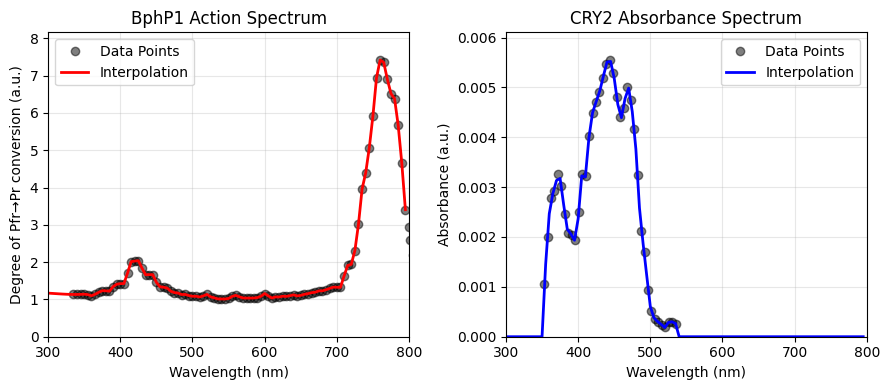

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# BphP1
ax1.plot(df_bphp1['X'], df_bphp1['Y'], 'o', label='Data Points', color='black', alpha=0.5)
ax1.plot(x_red, y_red, '-', label='Interpolation', color='r', linewidth=2)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Degree of Pfr→Pr conversion (a.u.)')
ax1.set_title('BphP1 Action Spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(lambda_min, lambda_max)
ax1.set_ylim(0, max(df_bphp1['Y']) * 1.1)

# CRY2
ax2.plot(df_cry2['X'], df_cry2['Y'], 'o', label='Data Points', color='black', alpha=0.5)
ax2.plot(x_blue, y_blue, '-', label='Interpolation', color='b', linewidth=2)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Absorbance (a.u.)')
ax2.set_title('CRY2 Absorbance Spectrum')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(lambda_min, lambda_max)
ax2.set_ylim(0, max(df_cry2['Y']) * 1.1)

plt.tight_layout()
plt.show()

Normalize both interpolations so the Y-values are between 0.0 and 1.0.

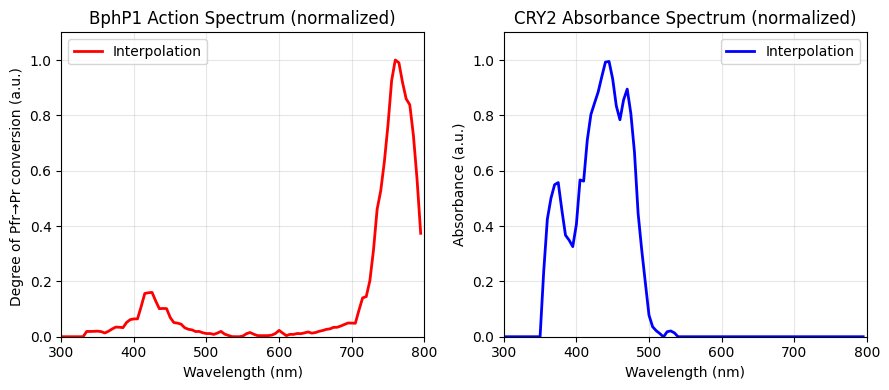

In [ ]:
y_bphp1_norm = ((df_bphp1['Y'] - df_bphp1['Y'].min()) / (df_bphp1['Y'].max() - df_bphp1['Y'].min())).tolist()
y_cry2_norm = ((df_cry2['Y'] - df_cry2['Y'].min()) / (df_cry2['Y'].max() - df_cry2['Y'].min())).tolist()

red_interp_norm = interp1d(df_bphp1['X'].tolist(), y_bphp1_norm,
                      kind='cubic', bounds_error=False, fill_value=0)
blue_interp_norm = interp1d(df_cry2['X'].tolist(), y_cry2_norm,
                      kind='cubic', bounds_error=False, fill_value=0)

y_red_norm = red_interp_norm(x_red)
y_blue_norm = blue_interp_norm(x_blue)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# BphP1 (with crosstalk)
ax1.plot(x_red, y_red_norm, '-', label='Interpolation', color='r', linewidth=2)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Degree of Pfr→Pr conversion (a.u.) ')
ax1.set_title('BphP1 Action Spectrum (normalized)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(lambda_min, lambda_max)
ax1.set_ylim(0, max(y_bphp1_norm) * 1.1)

# CRY2
ax2.plot(x_blue, y_blue_norm, '-', label='Interpolation', color='b', linewidth=2)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Absorbance (a.u.)')
ax2.set_title('CRY2 Absorbance Spectrum (normalized)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(lambda_min, lambda_max)
ax2.set_ylim(0, max(y_cry2_norm) * 1.1)

plt.tight_layout()
plt.show()

In [ ]:
def calculate_k_red(lambda1, threshold=True):
    '''
    np.log(2) / (19/60) = photoconversion half-life for BphP1 at 740nm

    `threshold` is whether you want to eliminate the BphP1-CRY2 crosstalk at 350-500 nm.
    '''
    k_red_prev = red_interp_norm(lambda1)
    if threshold and lambda1 < 600:  # Cut out the peak at ~415 nm
        k_red_prev = 0
    k_red = (np.log(2) / (19/60)) * k_red_prev
    return k_red

def calculate_k_blue(lambda2):
    '''
    np.log(2) / (5/60) = photoconversion half-life for BphP1 at 740nm
    '''
    k_blue = (np.log(2) / (5/60)) * blue_interp_norm(lambda2)
    return k_blue

# Constants

In [ ]:
k_red_reverse = np.log(2) / (210/60)  # Time rate for Pr -> Pfr
k_blue_reverse = np.log(2) / (12.5/60)  # Time rate for CRY2 to become inactive
k_YFP = 0.5  # Max YFP production rate

# Protein degradation
deg_BphP1 = 0.005
deg_CRY2 = 0.005
deg_hdimer = 0.01
deg_YFP = 0.01

# Total concentration of BphP1 and CRY2
BphP1_total = 4
CRY2_total = 4

# Binding
k_bind = 0.1
k_unbind = 0.05

n = 3  # Hill coefficient
K = 1.0

## ODE Model Function - d(YFP)/dt

In [ ]:
def ode_model(state, t, k_red, k_blue):
    '''
    Returns d(YFP)/dt.
    '''

    # Setting intensities constant for now - change this later!
    I_red = 1.0
    I_blue = 1.0

    [BphP1_Pr, CRY2_active, hdimer, YFP] = state

    BphP1_Pfr = BphP1_total - BphP1_Pr - hdimer
    CRY2_inactive = CRY2_total - CRY2_active - hdimer

    d_BphP1_Pr = (k_red * I_red * BphP1_Pfr) - (k_red_reverse * BphP1_Pr) - (deg_BphP1 * BphP1_Pr) - (k_bind * BphP1_Pr * CRY2_active) + (k_unbind * hdimer)
    d_CRY2_active = (k_blue * I_blue * CRY2_inactive) - (k_blue_reverse * CRY2_active) - (deg_CRY2 * CRY2_active) - (k_bind * BphP1_Pr * CRY2_active) + (k_unbind * hdimer)
    d_hdimer = (k_bind * BphP1_Pr * CRY2_active) - (k_unbind * hdimer) - (deg_hdimer * hdimer)
    d_YFP = k_YFP * (hdimer ** n / (K ** n + hdimer ** n)) - deg_YFP * YFP

    return [d_BphP1_Pr, d_CRY2_active, d_hdimer, d_YFP]

# Simulation Helper Functions

In [ ]:
def what_color_is_it(wavelength):
    color = ''
    if (350 <= wavelength <= 380):
        color = 'UV'
    elif (380 <= wavelength <= 445):
        color = 'violet'
    elif (445 < wavelength <= 475):
        color = 'blue'
    elif (475 < wavelength <= 510):
        color = 'cyan'
    elif (510 < wavelength <= 570):
        color = 'green'
    elif (570 < wavelength <= 590):
        color = 'yellow'
    elif (590 < wavelength <= 650):
        color = 'orange'
    elif (650 < wavelength <= 780):
        color = 'red'
    else:
        color = 'N/A'
    return color

In [ ]:
def simulate(lambda1, lambda2, initial_state=[0.0, 0.0, 0.0], t_max=2000, threshold=True):

    # We can do this because there's very little overlap between the
    # absorption spectra for BphP1 and CRY2! e.g. they don't compete
    k_red = calculate_k_red(lambda1, threshold) + calculate_k_red(lambda2, threshold)
    k_blue = calculate_k_blue(lambda1) + calculate_k_blue(lambda2)

    t = np.arange(0, t_max)

    solution = odeint(ode_model, initial_state, t, args=(k_red, k_blue))

    BphP1_Pr = solution[:, 0]
    CRY2_active = solution[:, 1]
    hdimer = solution[:, 2]
    YFP = solution[:, 3]

    # Plotting
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f'λ1 = {lambda1:.0f} nm ({what_color_is_it(lambda1)}), λ2 = {lambda2:.0f} nm ({what_color_is_it(lambda2)})',
                fontsize=14, fontweight='bold')

    axes = []
    axes.append(plt.subplot2grid((2, 3), (0, 0)))  # BphP1
    axes.append(plt.subplot2grid((2, 3), (0, 1)))  # CRY2
    axes.append(plt.subplot2grid((2, 3), (0, 2)))  # hdimer
    axes.append(plt.subplot2grid((2, 3), (1, 0), colspan=3))  # YFP - spans all columns

    # BphP1
    axes[0].plot(t, BphP1_Pr, '-', color='red', linewidth=2)
    axes[0].set_xlabel('Time (minutes)')
    axes[0].set_ylabel('BphP1 Pr (μM)')
    axes[0].set_title(f'BphP1 Pr (Active)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 5)

    # CRY2
    axes[1].plot(t, CRY2_active, '-', color='blue', linewidth=2)
    axes[1].set_xlabel('Time (minutes)')
    axes[1].set_ylabel('CRY2 Active (μM)')
    axes[1].set_title(f'CRY2 Active')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 5)

    # Heterodimer
    axes[2].plot(t, hdimer, '-', color='purple', linewidth=2)
    axes[2].set_xlabel('Time (minutes)')
    axes[2].set_ylabel('Heterodimer (μM)')
    axes[2].set_title(f'BphP1-CRY2 Complex')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0, 10)

    # YFP
    axes[3].plot(t, YFP, '-', color='#B59A00', linewidth=2)
    axes[3].set_xlabel('Time (minutes)')
    axes[3].set_ylabel('YFP (μM)')
    axes[3].set_title(f'YFP Output (Final: {YFP[-1]:.2f})')
    axes[3].grid(True, alpha=0.3)
    axes[3].set_ylim(0, 50)

    plt.tight_layout()
    plt.show()

    plt.style.use('default')
    print(f'Heterodimer concentration: {hdimer[-1]:.3f}  μM')
    print(f"Final YFP concentration: {YFP[-1]:.3f} μM")

# Simulation

In [ ]:
INIT_STATE = [0.0, 0.0, 0.0, 0.0]
MAX_TIME = 2000
NO_CROSSTALK = True

interact(simulate,
         lambda1=FloatSlider(min=350,
                             max=780,
                             step=5,
                             value=760,
                             description='λ1',
                             layout=Layout(width='840px'),
                             continuous_update=False),
         lambda2=FloatSlider(min=350,
                             max=780,
                             step=5,
                             value=450,
                             description='λ2',
                             layout=Layout(width='840px'),
                             continuous_update=False),
         initial_state=fixed(INIT_STATE),
         t_max=fixed(MAX_TIME),
         threshold=fixed(NO_CROSSTALK))

interactive(children=(FloatSlider(value=760.0, continuous_update=False, description='λ1', layout=Layout(width=…

<function __main__.simulate(lambda1, lambda2, initial_state=[0.0, 0.0, 0.0], t_max=2000, threshold=True)>